<a href="https://colab.research.google.com/github/Alakhras/Abalone-Age/blob/main/Abalone_UMSL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification using Tensorflow and Keras
Aladdin Alakhras, University of Missouri-St. Louis

### **Problem:**
* Abalones are endangered marine snails found in cold coastal waters worldwide,  Their price is positively correlated with age.
  However, determining abalone age is complex.
A machine learning model to classify abalone age would significantly accelerate this manual process, benefiting abalone researchers and adding value to the field.

* Dataset: [`Abalone.csv`](https://github.com/Alakhras/Abalone-Age/blob/main/Abalone.csv)
  - This project classifies abalone snails as "young" or "old" based on their ring count, using input features such as gender, height, weight, etc.
* Original data at [UCI ML database](https://archive.ics.uci.edu/dataset/1/abalone)

#Phase 1: Exploratory Data Analysis & preparation of the Abalone Data Set


  We are going to use physical and biological attributes of abalone to predict whether an abalone is old or young. There are 4177 observations in this data set and 8 features. We have sex as a categorical feature indicating whether an abalone is male, female or infant. We have other 7 numeric features which describe the size and weight of abalones.
The missing values have been removed in the original research so we do not have missing values here.


#Step 1: Load the Dataset, Clean It, and Preview Its Shape and the First 5 Rows#



In [ ]:
import os
import shap
import random
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from IPython.display import display, Markdown
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import layers, models # Import the models module
import warnings
warnings.filterwarnings('ignore')

In [ ]:
BASE_PATH = 'https://raw.githubusercontent.com/Alakhras/Abalone-Age/main/Abalone.csv'
dataset1 = pd.read_csv(BASE_PATH)
print(dataset1.shape)
dataset1.head()


(4177, 9)


Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

The minimum value in height is **zero**.
There are only two rows with **zero** values. We can remove these two rows from our dataset and consider the rest of the data for the model.

In [ ]:
dataset1 = dataset1[dataset1.Height != 0]
print(dataset1.shape)

(4175, 9)


*  Step 2: Prepare the output
*  Step 3: Shuffle the rows
*  Step 4: Split into Training/Validation Set

We categorize abalones based on their age, designating those with more than 10 rings as "old" and those with 10 rings or fewer as "young." This threshold is arbitrary, and we observe an imbalanced distribution of the target variable, which could affect our predictive modeling efforts. Addressing this imbalance is crucial for improving model performance and ensuring reliable classifications.

In [ ]:
dataset1["Is old"] = np.where(dataset1["Rings"] > 9, "Old", "Young")
dataset1.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings Is old  
0         0.150     15    Old  
1         0.070      7  Young  
2         0.210      9  Young  
3         0.155     10    Old  
4         0.055      7  Young

Then check if the data is imbalanced by calculating what percentage of the output labels are 0 and what percentage are 1 which is:

| Target       |  Old  | Young |
| -------------| ----- | ---   |
| Observations | 2081  | 2094  |.
| Percentage   | 49.8% | 50.2% |.

The dataset exhibits some imbalance but is sufficiently balanced for our analysis, allowing us to proceed with our modeling efforts.


##Shuffling the dataset for reliability
###Convert 'Sex' and 'Is old' columns to numeric representation


In [ ]:
# Shuffle the dataset
dataset1 = dataset1.sample(frac=1).reset_index(drop=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
# Convert 'Sex' column to numeric representation
dataset1['Sex'] = dataset1['Sex'].map({'M': 1, 'F': 0, 'I': 2}).astype(float)  # Apply astype(float) to the Series after mapping
#Convert 'Is old' column to numeric representation
dataset1['Is old'] = dataset1['Is old'].map({'Old': 1, 'Young': 0}).astype(float)  # Apply astype(float) to the Series after mapping
#dataset = dataset2.to_numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(dataset1.iloc[0:5, :].to_string()) # Use to_string() for a single table output

   Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  Shell weight  Rings  Is old
0  1.0   0.530     0.410   0.140        0.7545          0.3495          0.1715        0.2105      8     0.0
1  1.0   0.550     0.385   0.130        0.7275          0.3430          0.1625        0.1900      8     0.0
2  2.0   0.365     0.270   0.105        0.2155          0.0915          0.0475        0.0630      6     0.0
3  1.0   0.520     0.395   0.125        0.8115          0.4035          0.1660        0.2000      7     0.0
4  2.0   0.510     0.390   0.125        0.5970          0.2930          0.1265        0.1555      8     0.0


##Split into Training/Validation Set

835


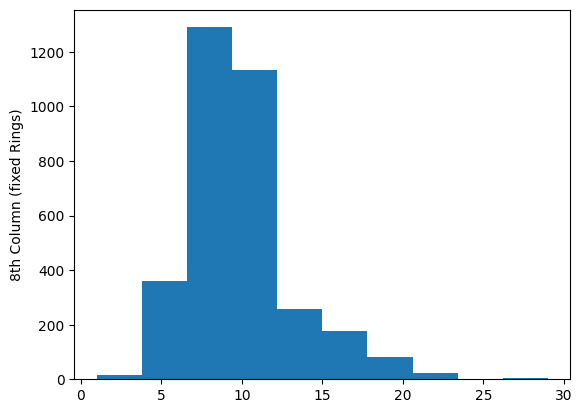

0      1      2      3       4       5       6       7     8
0  1.0  0.500  0.420  0.125  0.6200  0.2550  0.1500  0.2050  11.0
1  2.0  0.325  0.225  0.075  0.1390  0.0565  0.0320  0.0900   6.0
2  2.0  0.635  0.500  0.165  1.4890  0.7150  0.3445  0.3615  13.0
3  1.0  0.440  0.350  0.110  0.4585  0.2000  0.0885  0.1300   9.0
4  1.0  0.510  0.395  0.145  0.6185  0.2160  0.1385  0.2400  12.0

In [ ]:
index_20percent = int(0.2 * len(dataset1))  # Get 20% of the total number of rows
print(index_20percent)
# Create validation dataset (features and target together)
VALIDATION_DATA = dataset1.iloc[:index_20percent]
# Create training dataset (features and target together)
TRAINING_DATA = dataset1.iloc[index_20percent:]

XVALIDATION = dataset1.iloc[:index_20percent, :-1].values
YVALIDATION = dataset1.iloc[:index_20percent, -1].values

XTRAIN = dataset1.iloc[index_20percent:, :-1].values
YTRAIN = dataset1.iloc[index_20percent:, -1].values
plt.hist(XTRAIN[:, 8])
plt.ylabel('8th Column (fixed Rings)')
plt.show()
XTRAIN_df = pd.DataFrame(XTRAIN)
XTRAIN_df.head()

###Exploratory data analysis on training & validation sets

#### 3.1 Target variable distribution
Exploratory data analysis gives us a basic understanding of our train and validation data, and we may also find the some useful features to make young-old prediction for abalones. First, we plot the distribution of our target variable. The young-old class is derived from rings, so we also include the distribution of rings into our plot. From the figure we can observe a slightly right skewed distribution of `rings`. Since we set the threshold for old abalone as `rings > 10` , we get an unbalanced distribution of old and young abalone.

In [ ]:

# Distribution of our target: rings and is_old
alt.Chart(TRAINING_DATA, title="Distribution of target variables").mark_bar().encode(
    alt.X(alt.repeat(), type="nominal"), alt.Y("count()")
).repeat(["Rings", "Is old"])


alt.RepeatChart(...)

#### 3.2 Distribution of categorical variable
Sex is the only categorical variable in this data set. It has three categories: male, female and infant, denoted as M, F, I respectively. The distribution of sex is balanced.

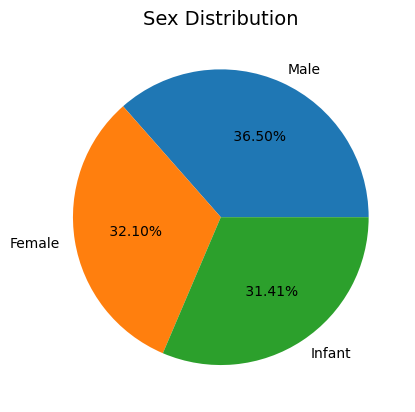

In [ ]:
# plot sex distribution
def plot_pie_chart():
    # Access the 'Sex' column instead of 'sex' (assuming the column name is 'Sex')
    values = TRAINING_DATA['Sex'].value_counts()
    labels = ['Male', 'Female', 'Infant']
    plt.pie(values, labels=labels, autopct=lambda p: f'{p: .2f}%')
    plt.title('Sex Distribution', size=14)
    plt.show()
plot_pie_chart()

#### 3.3 Distribution of continuous variables
We first get a summary table from our data set. However, this table does not contain intuitive information to help us make prediction.

In [ ]:
# Now you can use describe()
TRAINING_DATA.describe()

Sex       Length     Diameter       Height  Whole weight  \
count  3340.000000  3340.000000  3340.000000  3340.000000   3340.000000   
mean      1.006886     0.524132     0.407898     0.139735      0.833519   
std       0.796977     0.121868     0.100690     0.042905      0.497206   
min       0.000000     0.075000     0.055000     0.010000      0.002000   
25%       0.000000     0.450000     0.345000     0.115000      0.438500   
50%       1.000000     0.545000     0.425000     0.140000      0.804250   
75%       2.000000     0.620000     0.485000     0.165000      1.166625   
max       2.000000     0.815000     0.650000     1.130000      2.825500   

       Shucked weight  Viscera weight  Shell weight        Rings       Is old  
count     3340.000000     3340.000000   3340.000000  3340.000000  3340.000000  
mean         0.361556        0.181734      0.239918     9.909581     0.501497  
std          0.224503        0.111013      0.141483     3.219842     0.500073  
min          0.001000        0.000500      0.001500     1.000000     0.000000  
25%          0.181875        0.091875      0.129000     8.000000     0.000000  
50%          0.339750        0.171500      0.235000    10.000000     1.000000  
75%          0.508625        0.257000      0.330000    11.000000     1.000000  
max          1.488000        0.641500      1.005000    29.000000     1.000000

Then we plot the distribution of all numeric features within two targeted classes.From the plot we can group the numeric variables into three groups: (length, diameter), (height), and (whole_weight, shucked_weight, viscera_weight, shell_weight).  
The first group is left skewed. The means of two classes are similar and the old abalones have less deviation from mean.The second group has some outliers and the third group is right skewed. In the third group, we can observe a difference in mean weights and the distribution of old abalones are more bell-shaped.

In [ ]:
# Distribution of numeric variables: 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'
alt.Chart(TRAINING_DATA, title="Distribution of numeric variables").mark_bar(
    opacity=0.5
).encode(
    alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=50)),
    alt.Y("count()", stack=None),
    color=alt.Color("Is old:O", scale=alt.Scale(range=['#2ca02c', '#d62728']))  # Custom ordinal color palette
).repeat(
    [
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
    ],
    columns=2,
)


alt.RepeatChart(...)

####3.4 Correlation Analysis with Target Variable
In our analysis, we aim to explore the correlation between the selected predictor variables—length, height, and whole weight—and the target variable, rings. Our focus is also on identifying potential differences between young and old abalones.

Preliminary observations indicate a noticeable distinction in the regression lines when analyzing the relationships between the predictor variables (length and whole weight) and the target variable (rings) across the two classes. This suggests that the age classification of abalones may influence their physical characteristics and, consequently, their correlation with the number of rings.

In [ ]:
# Base scatter plot for Length vs. Rings
point_length = (
    alt.Chart(
        TRAINING_DATA,
        title="A Difference in Correlation Between Length and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X("Length:Q", title="Length"),
        y=alt.Y("Rings:Q", title="Rings"),
        color=alt.Color("Is old:N", title="Is Old")  # Ensure 'Is old' is treated as nominal
    )
)

# Regression lines for each group
regression_lines = point_length.transform_regression(
    "Length", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_length + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

In [ ]:
# Base scatter plot for Height vs. Rings
point_height = (
    alt.Chart(
        TRAINING_DATA,
        title="A Difference in Correlation Between Height and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.2)
    .encode(
        x=alt.X("Height:Q", title="Height"),
        y=alt.Y("Rings:Q", title="Rings"),
        color=alt.Color("Is old:N", title="Is Old")  # Ensure 'Is old' is treated as nominal
    )
)

# Regression lines for each group
regression_lines = point_height.transform_regression(
    "Height", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_height + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

In [ ]:
# Base scatter plot for Whole Weight vs. Rings
point_weight = (
    alt.Chart(
        TRAINING_DATA,
        title="A Difference in Correlation Between Whole Weight and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X("Whole weight:Q", title="Whole Weight"),  # Ensure whole weight is treated as quantitative
        y=alt.Y("Rings:Q", title="Rings"),                # Ensure rings is treated as quantitative
        color=alt.Color("Is old:N", title="Is Old")       # Treat 'Is old' as nominal
    )
)

# Regression lines for each group
regression_lines = point_weight.transform_regression(
    "Whole weight", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_weight + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

#### 3.5 Scatter Plots Showing the Relationship Between Continuous Features
We expect collinearity among the numeric features. Size measurements—length, diameter, and height—are strongly correlated with each other and also correlate with weight. This can be a concern for models sensitive to highly correlated features.

In the first group of scatter plots, we see that length, diameter, and height are linearly correlated. The relationship between size and weight, however, appears to be more non-linear. In the second group of scatter plots focused on weight, the correlations among weight features exist but are generally weaker than those among size features. The relationship between weight and age (rings) is not very clear, but there seems to be a slight positive correlation, suggesting that older abalones may weigh more.


In [ ]:
# Define the features to compare
features = ["Length", "Diameter", "Height", "Whole weight"]

# Create a scatter plot matrix for the specified features
scatter_matrix = alt.Chart(TRAINING_DATA, title="Scatter Plot Matrix of Numeric Variables").mark_point(
    size=5, opacity=0.1
).encode(
    x=alt.X(alt.repeat("row"), type="quantitative"),
    y=alt.Y(alt.repeat("column"), type="quantitative"),
).properties(
    height=200, width=200
).repeat(
    row=features,  # Rows correspond to features for the y-axis
    column=features  # Columns correspond to features for the x-axis
)

# Display the scatter plot matrix
scatter_matrix.display()

alt.RepeatChart(...)

In [ ]:
# Define the features to compare
features = ["Shucked weight", "Viscera weight", "Shell weight", "Rings"]

# Create a scatter plot matrix for the specified features
scatter_matrix = alt.Chart(TRAINING_DATA, title="Scatter Plot Matrix of Numeric Variables").mark_point(
    size=5, opacity=0.1
).encode(
    x=alt.X(alt.repeat("column"), type="quantitative"),  # X-axis uses features for columns
    y=alt.Y(alt.repeat("row"), type="quantitative"),     # Y-axis uses features for rows
).properties(
    height=200, width=200
).repeat(
    column=features,  # Columns correspond to features for the x-axis
    row=features      # Rows correspond to features for the y-axis
)

# Display the scatter plot matrix
scatter_matrix.display()

alt.RepeatChart(...)

#### 3.6 Correlation Heat Map
A correlation heat map offers a visually intuitive representation of the relationships between all variables in our dataset. By examining the heat map, we can identify that the feature variables exhibit high levels of correlation. This visualization allows us to easily discern patterns and potential multicollinearity among the numeric features, which is critical for informing our modeling decisions and understanding the underlying data structure.

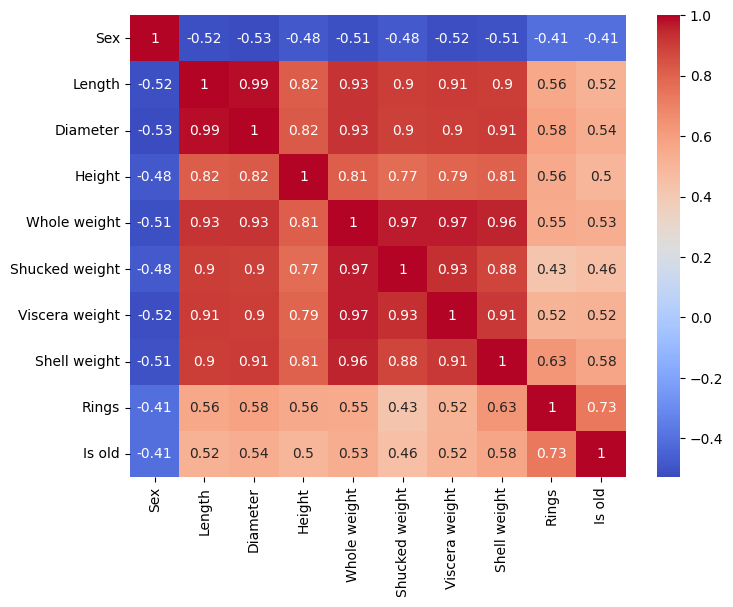

In [ ]:
# Calculate the correlation matrix only for numeric columns.
plt.figure(figsize=(8, 6))  # Adjust the figure size if desired
sns.heatmap(TRAINING_DATA.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.show()

###Phase 2: Build a model to overfit the entire dataset

*   Step 7: Create a neural network model
*   Step 8: Compile the model
*   Step 9: Train the model
*   Step 10: Check the learning curves
*   Step 11: Evaluate the model on the dataset
*   Step 13: Check what what the model actually predicts
*   Step 14: Is 'accuracy' sufficient to evaluate our model?


we want to determine how big architecture we need to overfit the data. The place to start is to use ‘logistic regression’ model and train for as many epochs as needed to obtain as high accuracy as possible so we will use the dataset without splitting then normalize it.

In [ ]:
# Separate features and target
X = dataset1.iloc[:, :-1].values
y = dataset1.iloc[:, -1].values

# Normalize features
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_normalized = (X - X_min) / (X_max - X_min)

#Model Creation and Training:

 The function create_compile_model initializes a neural network based on specified architecture. The initial model is set up as a logistic regression with one neuron. Training the model produces learning curves that illustrate how loss and accuracy evolve over epochs, providing insights into model performance.


In [ ]:

# 1. Model Creation and Training
def create_compile_model(input_shape, layers):
    model = Sequential()  # Initialize a Sequential model
    for i, neurons in enumerate(layers):
        if i == 0:
            model.add(Dense(neurons, input_shape=input_shape, activation='relu'))  # Input layer with ReLU activation
        else:
            model.add(Dense(neurons, activation='relu'))  # Hidden layers with ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# The initial model starts as a logistic regression model (1 neuron)
model = create_compile_model((X_normalized.shape[1],), [1])


In [ ]:
# Callbacks for ModelCheckpoint and EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)
# Fit the model with callbacks
history = model.fit(X_normalized, y,
                    epochs=200,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])  # Add the callbacks


Epoch 1/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5802 - loss: 0.6774
Epoch 2/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6950 - loss: 0.6335
Epoch 3/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7457 - loss: 0.6120
Epoch 4/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7734 - loss: 0.5946
Epoch 5/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7838 - loss: 0.5744
Epoch 6/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7839 - loss: 0.5619
Epoch 7/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - loss: 0.5443
Epoch 8/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7653 - loss: 0.5468
Epoch 9/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7625 - loss: 0.5344
Epoch 10/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7667 - loss: 0.5323
Epoch 11/200
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7605 - loss: 0.5218
Epoch 12/200
131/131 ━━━━━━━━━━━━━━━━━━━━

#Evaluation:
After training, the model is evaluated on the entire dataset. Predictions are generated, enabling the calculation of accuracy, precision, recall, and F1 score. Displaying the first ten predictions alongside the actual values provides a direct comparison, allowing for assessment of prediction quality.

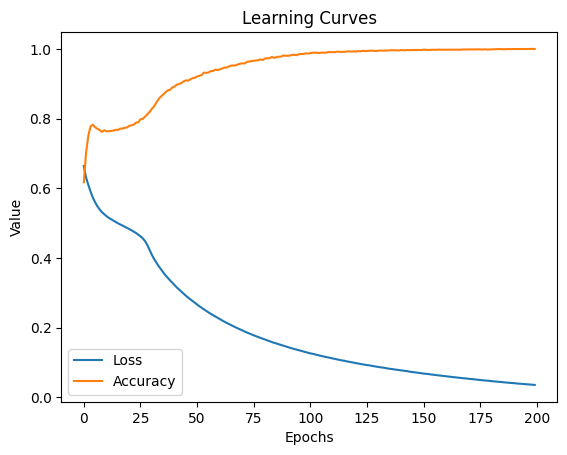



131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 0.0339
Final accuracy on entire dataset: 99.98%


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predictions:         [0.00 0.00 0.00 0.00 0.00 0.99 0.99 0.85 0.99 0.00]
Binary Predictions:  [0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 1.00 0.00]
True Values:         [0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 1.00 0.00]
Precision:           99.95%
Recall:              100.00
F1 Score:            99.98


In [ ]:
# Plot learning curves
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()
print('\n')
# 2. Evaluation: The model is evaluated on the entire dataset, and predictions are made,
# followed by calculating additional metrics (precision, recall, and F1 score).
accuracy = model.evaluate(X_normalized, y, verbose=1)[1]
print(f'Final accuracy on entire dataset: {accuracy * 100:.2f}%')
print('\n')
# Check model predictions
predictions = model.predict(X_normalized).flatten()  # Get raw predictions
predictions_binary = np.round(predictions)  # Convert predictions to binary (0 or 1)
print('\n')
# Analyze predictions
print(f'Predictions:         {predictions[:10]}')
print(f'Binary Predictions:  {predictions_binary[:10]}')
print(f'True Values:         {y[:10]}')

# Additional Metrics
precision = precision_score(y, predictions_binary)
recall = recall_score(y, predictions_binary)
f1 = f1_score(y, predictions_binary)

print(f'Precision:           {precision * 100:.2f}%')
print(f'Recall:              {recall * 100:.2f}')
print(f'F1 Score:            {f1 * 100:.2f}')

#Iterative Model Growth:
  The function iteratively_increase_model systematically tests various configurations of the neural network by varying the number of neurons in the hidden layer. The architectures tested include 2, 4, 8, 16, 32, and 64 neurons. Each configuration's accuracy is evaluated:

Architecture Evaluation: After fitting the model for each specified number of neurons, its accuracy is calculated. All tested architectures are logged for later review.
Overfitting Check: The evaluation stops if any architecture achieves an accuracy of 99.5%, which could indicate overfitting.
Summary of Results: After testing all configurations, a summary is printed to show the performance of each tested architecture and highlight the best-performing configuration. This iterative process aims to discover the optimal architecture that can overfit the dataset, which will later guide efforts to simplify the model for better generalization.
The function iteratively_increase_model tests various configurations by changing the number of neurons in the hidden layer. It tracks the accuracy for each architecture tested and identifies the configuration that performs best. The process stops when a model achieves at least 99.5% accuracy, indicating potential overfitting.

The function also records and prints a summary of results, detailing how each architecture performed, which is crucial in determining the minimal architecture needed to potentially overfit the dataset. Insights gained from this iterative growth will guide the process of model simplification for generalization in later phases.

In [ ]:
# 3. Iterative Model Growth: A separate function is implemented to test various neuron configurations (2, 4, 8, 16 neurons).
def iteratively_increase_model():
    architectures_tested = []
    best_accuracy = 0
    best_architecture = None

    # Vary the number of neurons in simple iterative architectures
    for neurons in [2, 4, 8, 16, 32, 64]:
        print(f"\nTesting architecture with {neurons} neurons")
        model = create_compile_model((X_normalized.shape[1],), [neurons])
        history = model.fit(X_normalized, y, epochs=500, verbose=0)  # Increase epochs for deeper training

        # Evaluate the model on the entire dataset
        accuracy = model.evaluate(X_normalized, y, verbose=0)[1]
        architectures_tested.append((neurons, accuracy * 100))

        print(f'Architecture with [{neurons}] neurons achieved accuracy: {accuracy * 100:.2f}%')

        # Check if this architecture overfits well
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_architecture = neurons

        # Break if exceeding 99% accuracy signifies overfitting
        if accuracy >= 0.995:
            print(f'Overfit achieved with architecture [{neurons}].\n')
            break
# Print summary of results
    print("\nSummary of model architectures tested:")
    for neurons, acc in architectures_tested:
        print(f'Neurons: {neurons}, Accuracy: {acc:.2f}%')

    print(f"\nBest Architecture: [{best_architecture}] neurons with accuracy {best_accuracy * 100:.2f}%")

# Run the architecture testing
iteratively_increase_model()


Testing architecture with 2 neurons
Architecture with [2] neurons achieved accuracy: 100.00%
Overfit achieved with architecture [2].


Summary of model architectures tested:
Neurons: 2, Accuracy: 100.00%

Best Architecture: [2] neurons with accuracy 100.00%


##Normalize the dataset
*   Step 5: Normalize (if needed)
*   Step 6: Review the dimensions of training & validation set


835


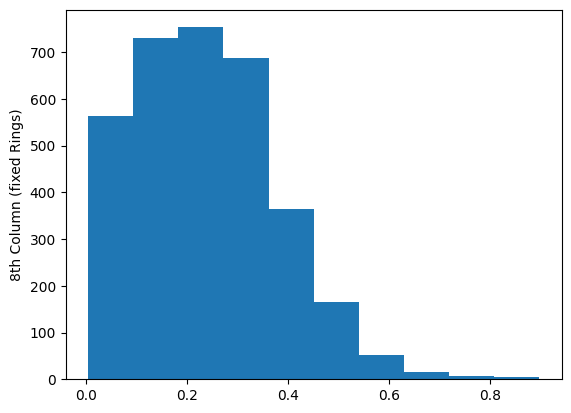

0      1      2      3       4       5       6       7
0  2.0  0.415  0.325  0.100  0.3850  0.1670  0.0800  0.1250
1  1.0  0.280  0.200  0.080  0.0915  0.0330  0.0215  0.0300
2  2.0  0.185  0.130  0.045  0.0290  0.0120  0.0075  0.0095
3  0.0  0.550  0.380  0.165  1.2050  0.5430  0.2940  0.3345
4  1.0  0.360  0.295  0.130  0.2765  0.0895  0.0570  0.1005

In [ ]:
shuffled_dataset = dataset1.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
index_20percent = int(0.2 * len(shuffled_dataset))  # Get 20% of the total number of rows
print(index_20percent)
XVALIDATION = shuffled_dataset.iloc[:index_20percent, :-2].values
YVALIDATION = shuffled_dataset.iloc[:index_20percent, -1].values

XTRAIN = shuffled_dataset.iloc[index_20percent:, :-2].values
YTRAIN = shuffled_dataset.iloc[index_20percent:, -1].values

plt.hist(XTRAIN[:, 7])
plt.ylabel('8th Column (fixed Rings)')
plt.show()
XTRAIN_df = pd.DataFrame(XTRAIN)
XTRAIN_df.head()

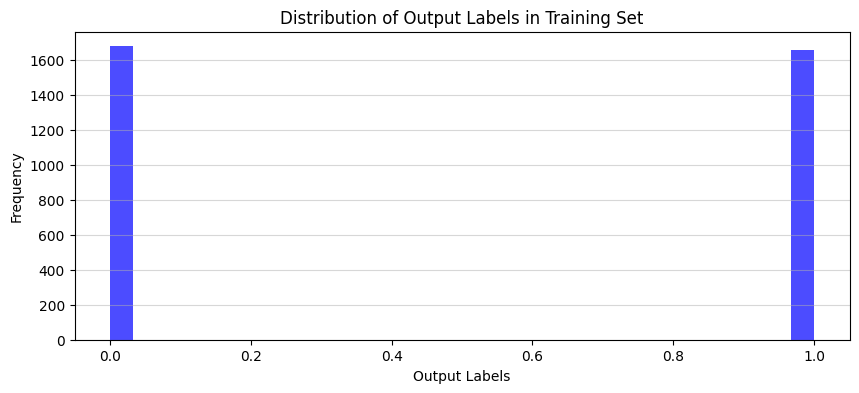

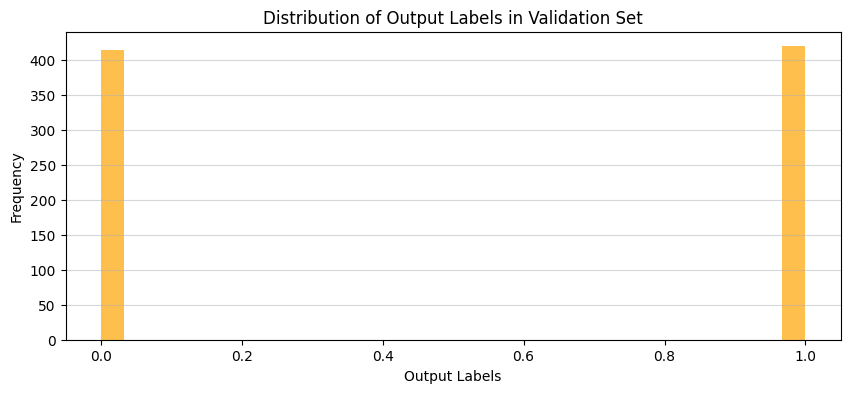

In [ ]:
# Histogram for training set output labels
plt.figure(figsize=(10, 4))  # Set figure size
plt.hist(YTRAIN, bins=30, color='blue', alpha=0.7)  # Adjust number of bins and color
plt.title('Distribution of Output Labels in Training Set')  # Title for the histogram
plt.xlabel('Output Labels')  # X-axis label
plt.ylabel('Frequency')      # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

# Histogram for validation set output labels
plt.figure(figsize=(10, 4))  # Set figure size
plt.hist(YVALIDATION, bins=30, color='orange', alpha=0.7)  # Adjust number of bins and color
plt.title('Distribution of Output Labels in Validation Set')  # Title for the histogram
plt.xlabel('Output Labels')  # X-axis label
plt.ylabel('Frequency')      # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

In [ ]:
# Convert to NumPy array after preprocessing
dataset = np.array(dataset1)

# Shuffle the dataset
# Convert dataset back to DataFrame for shuffling and further processing
dataset = pd.DataFrame(dataset, columns=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                                       'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings', 'Is old'])
shuffled_dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X = shuffled_dataset[['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                      'Shucked weight', 'Viscera weight', 'Shell weight']]
y = shuffled_dataset['Is old']

# Min-Max Normalization
normalized_X = (X - X.min()) / (X.max() - X.min())

# Split indices
split_index = int(0.8 * len(normalized_X))
XTRAIN = normalized_X.iloc[:split_index]
YTRAIN = y.iloc[:split_index]
XVALIDATION = normalized_X.iloc[split_index:]
YVALIDATION = y.iloc[split_index:]

In [ ]:
# Print shapes of the datasets
print("Shapes of the datasets:")
print("XTRAIN shape:", XTRAIN.shape)
print("YTRAIN shape:", YTRAIN.shape)
print("X_VALIDATION_normalized shape:", XVALIDATION.shape)
print("X_TRAIN_normalized shape:", XTRAIN.shape)
print("YVALIDATION shape:", YVALIDATION.shape)

# Print first three rows of each dataset
print("\nFirst three entries of the datasets:")
print("XTRAIN (first 3 rows):")
print(XTRAIN.iloc[0:3])  # Use .iloc for row slicing in DataFrames
print("YTRAIN (first 3 entries):")
print(YTRAIN.iloc[0:3]) # Use .iloc for row slicing in Series

print("\nX_VALIDATION_normalized (first 3 rows):")
print(XVALIDATION.iloc[0:3])  # Use .iloc for row slicing in DataFrames
print("X_TRAIN_normalized (first 3 rows):")
print(XTRAIN.iloc[0:3])  # Use .iloc for row slicing in DataFrames

print("\nYVALIDATION (first 3 entries):")
print(YVALIDATION.iloc[0:3])  # Use .iloc for row slicing in Series

Shapes of the datasets:
XTRAIN shape: (3340, 8)
YTRAIN shape: (3340,)
X_VALIDATION_normalized shape: (835, 8)
X_TRAIN_normalized shape: (3340, 8)
YVALIDATION shape: (835,)

First three entries of the datasets:
XTRAIN (first 3 rows):
   Sex    Length  Diameter    Height  Whole weight  Shucked weight  \
0  0.0  0.479730  0.453782  0.098214      0.156897        0.110289   
1  0.5  0.777027  0.773109  0.156250      0.486099        0.503699   
2  0.0  0.797297  0.789916  0.151786      0.558350        0.455279   

   Viscera weight  Shell weight  
0        0.130349      0.152965  
1        0.236998      0.366218  
2        0.300856      0.452915  
YTRAIN (first 3 entries):
0    0.0
1    1.0
2    1.0
Name: Is old, dtype: float64

X_VALIDATION_normalized (first 3 rows):
      Sex    Length  Diameter    Height  Whole weight  Shucked weight  \
3340  0.5  0.533784  0.537815  0.107143      0.204533        0.143578   
3341  0.0  0.804054  0.890756  0.133929      0.462901        0.365501   
3342  0.

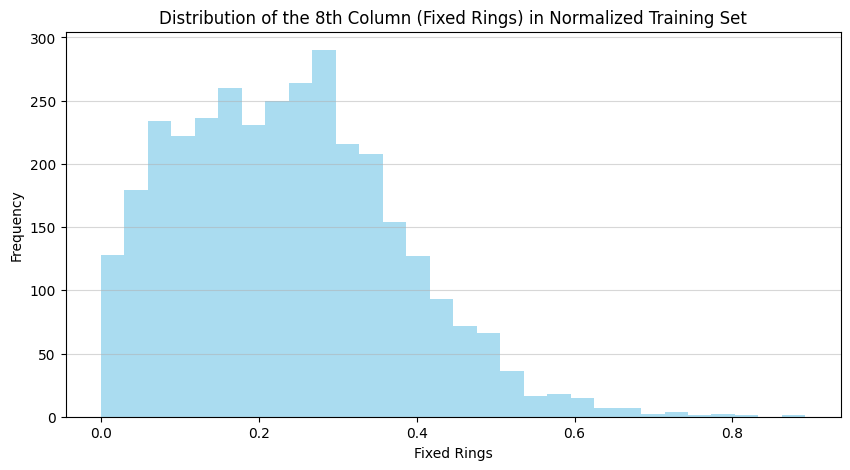

In [ ]:
# Plot histogram for the 8th column of the normalized training set
plt.figure(figsize=(10, 5))  # Set figure size for better visibility
# Access the 8th column (index 7) using .iloc
plt.hist(XTRAIN.iloc[:, 7], bins=30, color='skyblue', alpha=0.7)  # Specify the number of bins and colors
plt.title('Distribution of the 8th Column (Fixed Rings) in Normalized Training Set')  # Title for the histogram
plt.xlabel('Fixed Rings')  # X-axis label
plt.ylabel('Frequency')     # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

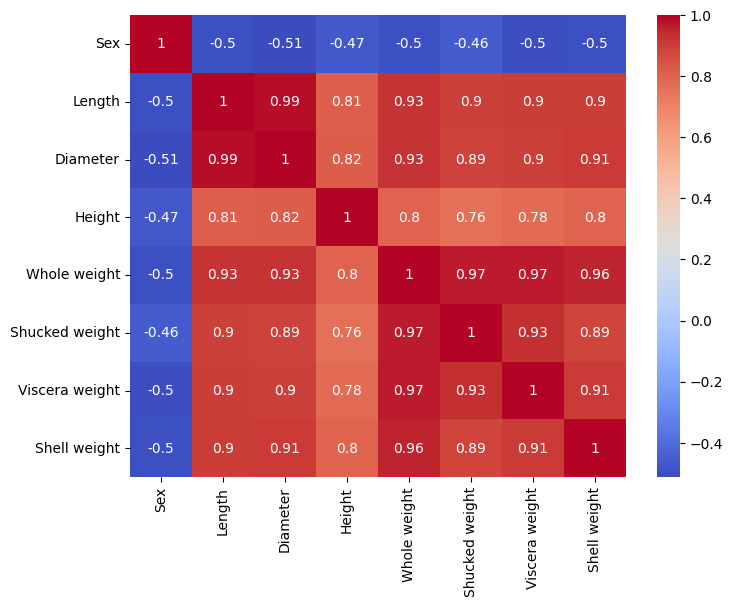

In [ ]:
# Calculate the correlation matrix only for numeric columns.
dataset_df = pd.DataFrame(XTRAIN)
plt.figure(figsize=(8, 6))  # Adjust the figure size if desired
sns.heatmap(dataset_df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.show()

#Phase 3: Model selection & evaluation
*   Step 7: Create a neural network model
*   Step 8: Compile the model
*   Step 9: Train the model
*   Step 10: Check the learning curves
*   Step 11: Evaluate the model on the training data
*   Step 12: Evaluate on validation set
*   Step 13: Check what the model actually predicts
*   Step 14: Is 'accuracy' sufficient to evaluate our model?


#This code implements a machine learning workflow:
 that starts by defining and training a logistic regression model as a baseline for binary classification. It then evaluates multiple neural network architectures to improve performance, using ReLU activation in hidden layers and a sigmoid activation for the output layer. The models are trained and evaluated based on key metrics, including accuracy, precision, recall, and F1 score. Learning curves are plotted to visualize performance over epochs, and the best-performing model is saved using model checkpointing and early stop. Finally, a classification report summarizes the model's predictive capabilities, identifying the architecture that achieved the highest validation accuracy.

In [ ]:
# Load dataset
BASE_PATH = 'https://raw.githubusercontent.com/Alakhras/Abalone-Age/main/Abalone.csv'
dataset = pd.read_csv(BASE_PATH)

# Clean the dataset and preprocess
dataset = dataset[dataset.Height != 0]
dataset["Rings"] = np.where(dataset["Rings"] < 9 , 0, 1)
dataset['Sex'] = dataset['Sex'].map({'M': 1, 'F': 0, 'I': 2}).astype(float)

# Shuffle the dataset
shuffled_dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X = shuffled_dataset[['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                      'Shucked weight', 'Viscera weight', 'Shell weight']]
y = shuffled_dataset['Rings']

# Min-Max Normalization
normalized_X = (X - X.min()) / (X.max() - X.min())

# Split indices
split_index = int(0.8 * len(normalized_X))
XTRAIN = normalized_X.iloc[:split_index]
YTRAIN = y.iloc[:split_index]
XVALIDATION = normalized_X.iloc[split_index:]
YVALIDATION = y.iloc[split_index:]

XTRAIN.head()

Sex    Length  Diameter    Height  Whole weight  Shucked weight  \
0  0.5  0.695946  0.680672  0.129464      0.320170        0.219233   
1  0.5  0.317568  0.319328  0.075893      0.052417        0.034633   
2  1.0  0.398649  0.378151  0.071429      0.081813        0.060188   
3  1.0  0.608108  0.630252  0.125000      0.260138        0.216207   
4  0.0  0.689189  0.680672  0.138393      0.374004        0.326160   

   Viscera weight  Shell weight  
0        0.194865      0.332337  
1        0.044108      0.046338  
2        0.071099      0.068261  
3        0.211323      0.212755  
4        0.328506      0.291480

In [ ]:
# Model Checkpointing and Early Stopping
checkpoint_path = 'best_model.keras' # Changed the file extension to .h5 and removed the weights from the file name
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1) # Removed save_weights_only=True
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,verbose=1)

# Enhanced Model Creation Function
def create_model(layer_sizes):
    model = models.Sequential()
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))  # Adding Dropout for regularization
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define neural network architectures to evaluate
model_architectures = [
    (2, 1),  # Model 1
    (4, 1),  # Model 2
    (8, 1),  # Model 3
    (16, 8, 1),  # Model 4
    (32, 16, 8, 1),  # Model 5
    (64, 32, 16, 8, 1)  # Model 6
]

# Store results
results = []

# Train and evaluate neural network models
for arch in model_architectures:
    model = create_model(arch)
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION),
                        epochs=200, batch_size=8, verbose=1,
                        callbacks=[checkpoint, early_stopping])
    # Evaluate the model
    train_loss, train_acc = model.evaluate(XTRAIN, YTRAIN, verbose=0)
    val_loss, val_acc = model.evaluate(XVALIDATION, YVALIDATION, verbose=0)
    total_params = model.count_params()

    results.append((str(arch), train_acc, val_acc, train_loss, val_loss, total_params))


Epoch 1/200
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7492 - loss: 0.5873
Epoch 1: val_loss improved from inf to 0.48657, saving model to best_model.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7492 - loss: 0.5872 - val_accuracy: 0.8240 - val_loss: 0.4866
Epoch 2/200
417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 0.5453
Epoch 2: val_loss improved from 0.48657 to 0.46536, saving model to best_model.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7632 - loss: 0.5453 - val_accuracy: 0.8287 - val_loss: 0.4654
Epoch 3/200
400/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.5526
Epoch 3: val_loss improved from 0.46536 to 0.45849, saving model to best_model.keras
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7565 - loss: 0.5520 - val_accuracy: 0.8287 - val_loss: 0.4585
Epoch 4/200
415/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7560 - loss: 0.5339
Epoch 4: val_loss did not improve from 0.45849
418

# Results summary

In [ ]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model Architecture', 'Acc. on Training Set', 'Acc. on Validation Set', 'Training Loss', 'Validation Loss', 'Total Parameters'])

# Print results summary
print("\nResults Summary:\n")
print(results_df.to_string(index=False))

# Load the best model based on validation loss
best_model = models.load_model(checkpoint_path) # Now models is defined and load_model can be accessed
print("\nBest model loaded from:", checkpoint_path)


Results Summary:

Model Architecture  Acc. on Training Set  Acc. on Validation Set  Training Loss  Validation Loss  Total Parameters
            (2, 1)              0.840719                0.850299       0.382159         0.377166                35
            (4, 1)              0.662275                0.668263       0.652111         0.648960                63
            (8, 1)              0.843114                0.840719       0.365871         0.362867               119
        (16, 8, 1)              0.818263                0.828743       0.519413         0.516859               391
    (32, 16, 8, 1)              0.816168                0.803593       0.542900         0.541522              1191
(64, 32, 16, 8, 1)              0.707784                0.737725       0.590900         0.585836              3815

Best model loaded from: best_model.keras


#Plot Learning Curves:
 Learning curves for each architecture are plotted to visualize how both training and validation accuracies evolve over epochs. This helps identify how well each model learns and if any of them are overfitting.

Load the Best Model: The model with the best performance (lowest validation loss) is loaded for final evaluation.


Epoch 1/200
411/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7291 - loss: 0.6026
Epoch 1: val_loss did not improve from 0.36287
418/418 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7291 - loss: 0.6023 - val_accuracy: 0.8156 - val_loss: 0.5300
Epoch 2/200
406/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7350 - loss: 0.5505
Epoch 2: val_loss did not improve from 0.36287
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7350 - loss: 0.5505 - val_accuracy: 0.8228 - val_loss: 0.4725
Epoch 3/200
411/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7441 - loss: 0.5405
Epoch 3: val_loss did not improve from 0.36287
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7443 - loss: 0.5404 - val_accuracy: 0.8251 - val_loss: 0.4523
Epoch 4/200
412/418 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - loss: 0.5287
Epoch 4: val_loss did not improve from 0.36287
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7384 - loss: 0.5287 - val_accuracy: 0.8228 - val_loss: 0.4

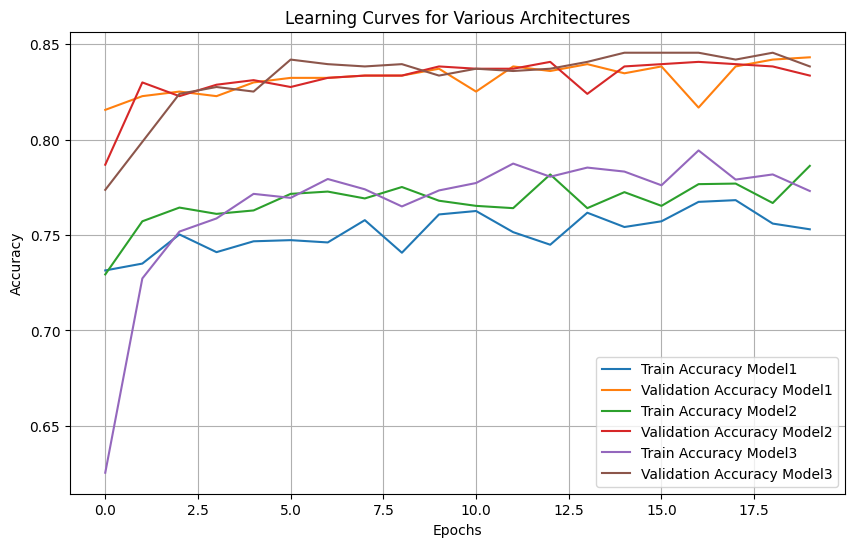

In [ ]:
def plot_all_learning_curves(histories, model_names):
    plt.figure(figsize=(10, 6))

    # Loop through each model's history and plot accuracy
    for history, arch in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label='Train Accuracy ' + str(arch))
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy ' + str(arch))

    # Customize the plot
    plt.title('Learning Curves for Various Architectures')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming 'histories' contains the training history for each model
# and 'model_names' is the list of corresponding model names
# Instead of using undefined variables, store the history objects during model training
histories = []  # Initialize an empty list to store histories
model_names = ['Model1', 'Model2', 'Model3']  # Define model names

# Train the first three models and store their histories
for i, arch in enumerate(model_architectures[:3]):  # Train only the first three models
    model = create_model(arch)
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION),
                        epochs=200, batch_size=8, verbose=1,
                        callbacks=[checkpoint, early_stopping])
    histories.append(history)  # Append the history object to the list

# Now you can plot the learning curves using the stored histories
plot_all_learning_curves(histories, model_names)

# Feature importance visualization using SHAP


# ROC AUC Evaluation


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


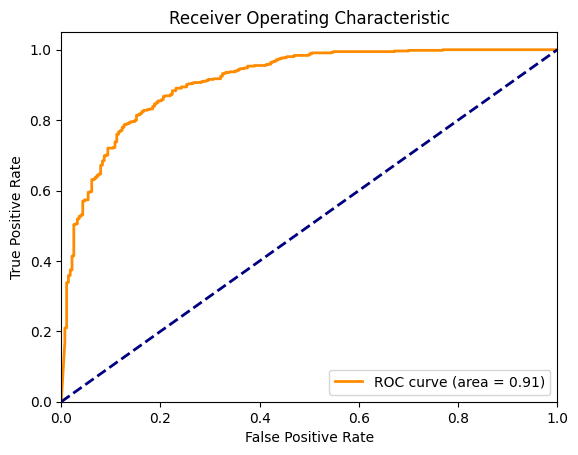

ROC AUC Score: 91.0 %


In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC AUC Evaluation
y_pred_proba = best_model.predict(XVALIDATION).flatten()  # Get predicted probabilities
fpr, tpr, thresholds = roc_curve(YVALIDATION, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC Score
print("ROC AUC Score:", roc_auc.round(2) * 100,"%")


#Predictions and Metrics:
 Predictions are generated for the validation set using the best model. A custom classification report function calculates metrics such as accuracy, precision, recall, and F1 score based on the predictions, providing a detailed assessment of the model's predictive performance.

 Make predictions on the validation set Evaluate the model using additional metrics


In [ ]:
# Make predictions on the validation set
y_pred = (best_model.predict(XVALIDATION) > 0.5).astype(int)  # Use best_model for predictions

# Custom classification report function
def classification_report(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)  # Reshape y_pred to match y_true
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True Negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0.0

    return {
        'Accuracy': accuracy.round(2) * 100,
        'Precision': precision.round(2) * 100,
        'Recall': recall.round(2) * 100,
        'F1 Score': f1_score.round(2) *100
    }

# Evaluate the model using additional metrics
report = classification_report(YVALIDATION, y_pred)

# Print the classification report
print('\nClassification Report:')
for key, value in report.items():
    print(f"{key}: {value:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
Accuracy: 84.0000
Precision: 84.0000
Recall: 95.0000
F1 Score: 89.0000


Print logistic regression results (example, needs to be defined previously)
Replace with your logistic regression results variables (if available)

In [ ]:
# Baseline Random Classifier Implementation
from sklearn.metrics import accuracy_score  # Import accuracy_score

class RandomBaselineClassifier:
    def __init__(self):
        self.class_probs = None

    def fit(self, y):
        # Calculate probabilities for each class based on the training target
        class_counts = y.value_counts(normalize=True)
        self.class_probs = class_counts

    def predict(self, X):
        # Randomly assign class based on learned probabilities
        return np.random.choice(self.class_probs.index, size=len(X), p=self.class_probs.values)

# Train the random baseline model
baseline_model = RandomBaselineClassifier()
baseline_model.fit(YTRAIN)

# Make predictions on the validation set
random_predictions = baseline_model.predict(XVALIDATION)
# Print results summary
print("\nResults Summary:")
print("_______________________________________________________________________________________")

# Baseline Logistic Regression Implementation
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y, epochs=1000, learning_rate=0.01):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        m = len(y)

        for _ in range(epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / m) * np.dot(X.T, (y_predicted - y))
            db = (1 / m) * np.sum(y_predicted - y)
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > 0.5).astype(int)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(XTRAIN, YTRAIN)

# Calculate accuracies
logistic_acc_train = np.mean(logistic_model.predict(XTRAIN) == YTRAIN)  # Accuracy on training set
logistic_acc_val = np.mean(logistic_model.predict(XVALIDATION) == YVALIDATION)  # Accuracy on validation set
# Calculate accuracy for the random baseline model
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model Architecture', 'Acc. on Training Set', 'Acc. on Validation Set', 'Training Loss', 'Validation Loss', 'Total Parameters'])
print(results_df.to_string(index=False))

random_accuracy = accuracy_score(YVALIDATION, random_predictions) # Now accuracy_score is defined
print(f'Random Baseline Classifier Accuracy: {random_accuracy:.4f}')

# Print logistic regression results
print('Logistic Regression - Training Accuracy: {:.4f}  Validation Accuracy: {:.4f}\n'.format(logistic_acc_train, logistic_acc_val))

# Load the best model based on validation loss
best_model = models.load_model(checkpoint_path) # Now models is defined and load_model can be accessed
print("\nBest model loaded from:", checkpoint_path)

# Conclusion about model performance
best_architecture = model_architectures[np.argmax([result[2] for result in results])]
print(f'\nThe best performing model architecture is: {best_architecture} with validation accuracy: {max([result[2] for result in results]):.4f}')

# Extract weights and biases from the trained model
weights = [layer.get_weights()[0] for layer in model.layers if layer.get_weights()]
biases = [layer.get_weights()[1] for layer in model.layers if layer.get_weights()]

# Print the number of weights and biases
print(f"\nNumber of weights for each layer: {[w.shape for w in weights]}")
print(f"Number of biases for each layer: {[b.shape for b in biases]}")



Results Summary:
_______________________________________________________________________________________
Model Architecture  Acc. on Training Set  Acc. on Validation Set  Training Loss  Validation Loss  Total Parameters
            (2, 1)              0.840719                0.850299       0.382159         0.377166                35
            (4, 1)              0.662275                0.668263       0.652111         0.648960                63
            (8, 1)              0.843114                0.840719       0.365871         0.362867               119
        (16, 8, 1)              0.818263                0.828743       0.519413         0.516859               391
    (32, 16, 8, 1)              0.816168                0.803593       0.542900         0.541522              1191
(64, 32, 16, 8, 1)              0.707784                0.737725       0.590900         0.585836              3815
Random Baseline Classifier Accuracy: 0.5365
Logistic Regression - Training Accuracy: 0.73

Custom prediction function using the trained model


In [ ]:
def my_prediction_function(model, data):
    output = data
    for layer in model.layers:
        if layer.get_weights():  # Check if the layer has weights
            # Check if the layer has only weights and bias
            if len(layer.get_weights()) == 2:
                weights, bias = layer.get_weights()  # Extract weights and bias
                output = np.dot(output, weights) + bias  # Apply linear transformation
            # Handle layers with more than two weight elements (e.g., BatchNormalization)
            else:
                # Apply the layer's call method to the output
                output = layer.call(output)

        # Apply activation function (if any)
        if hasattr(layer, 'activation'):
            if layer.activation.__name__ == 'relu':
                output = np.maximum(0, output)
            elif layer.activation.__name__ == 'sigmoid':
                output = 1 / (1 + np.exp(-output))

    return output

# Example of passing the validation data to be predicted
custom_predictions = my_prediction_function(best_model, XVALIDATION)

# Print custom predictions
print("\nCustom Predictions using my_prediction_function:")
print(custom_predictions[35:45].round())
print(y_pred[35:45].round()) # Compare with predictions from the best_model

# Generate predictions on the validation data using your custom function
# CHANGED: Use XVALIDATION instead of XTRAIN to get predictions on the validation data
validation_predictions = my_prediction_function(best_model, XVALIDATION)

# Check if predictions are approximately the same
# CHANGED: Compare custom_predictions with validation_predictions (both on validation data)
assert np.allclose(validation_predictions, custom_predictions), "Predictions do not match!"
print("Predictions from both methods are the same.")
# Final Statements
print("\nProcess completed successfully!")


Custom Predictions using my_prediction_function:
[[0.00]
 [1.00]
 [1.00]
 [0.00]
 [0.00]
 [1.00]
 [0.00]
 [1.00]
 [1.00]
 [0.00]]
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]
Predictions from both methods are the same.

Process completed successfully!


#Discussion on Architecture Size for Overfitting with Output as an Additional Input Feature
When you incorporate the output variable as an extra input feature in your model, you’re essentially providing the model with more data to work with. This additional information can help the model identify more specific patterns and details in the training data.

In simpler terms, if you use a basic model with fewer layers and neurons, it may have trouble grasping the complexities of the data, particularly with this new input. On the other hand, more complex architectures—those with more layers and neurons—offer greater capacity for learning but come with the risk of overfitting.

To achieve overfitting, you might need a model with several hidden layers and a greater number of neurons in each layer (for instance, a structure like 64-32-16-8). Such a deeper network is likely necessary to effectively capture the relationships and dependencies that arise when including the output variable as input. However, it’s crucial to monitor the validation loss to verify whether overfitting truly occurs.

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)                    │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6558 - loss: 0.6354 - val_accuracy: 0.9617 - val_loss: 0.4826
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.4603 - val_accuracy: 0.9066 - val_loss: 0.4068
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9215 - loss: 0.3927 - val_accuracy: 0.9114 - val_loss: 0.3638
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9224 - loss: 0.3523 - val_accuracy: 0.9234 - val_loss: 0.3327
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9335 - loss: 0.3240 - val_accuracy: 0.9341 - val_loss: 0.3085
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.3080 - val_accuracy: 0.9401 - val_loss: 0.2888
Epoch 7/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9421 - loss: 0.2862 - val_accuracy: 0.9449 - val_loss: 0.2725
Epoch 8/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.2722 - val_accurac

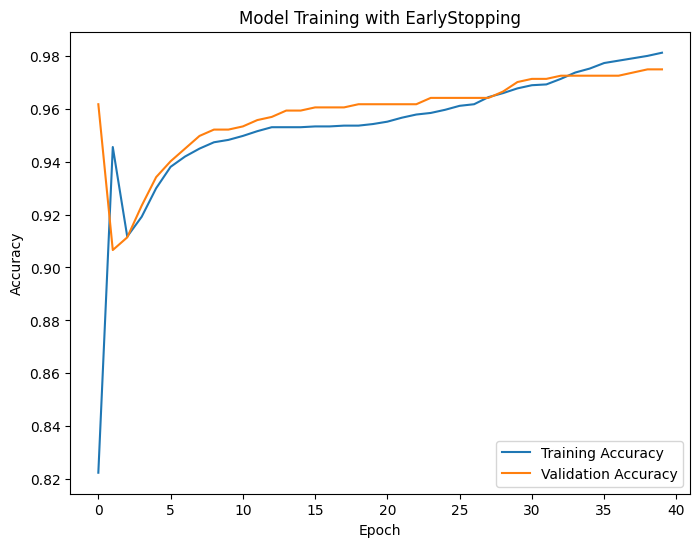

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
BASE_PATH = 'https://raw.githubusercontent.com/Alakhras/Abalone-Age/main/Abalone.csv'
dataset = pd.read_csv(BASE_PATH)

# Clean the dataset and preprocess
dataset = dataset[dataset['Height'] != 0]  # Remove rows with 'Height' == 0
dataset["Rings"] = np.where(dataset["Rings"] < 9, 0, 1)  # Binary classification for Rings
dataset['Sex'] = dataset['Sex'].map({'M': 1, 'F': 0, 'I': 2}).astype(float)

# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X = dataset[['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
             'Shucked weight', 'Viscera weight', 'Shell weight']]
y = dataset['Rings']

# Add the target variable 'Rings' (output) as a feature (input)
X_with_output = X.copy()  # Copy existing features
X_with_output['Rings'] = y  # Add the target as an input feature

# No normalization to force feature dominance
XTRAIN = X_with_output.iloc[:int(0.8 * len(X_with_output))]
YTRAIN = y.iloc[:int(0.8 * len(y))]
XVALIDATION = X_with_output.iloc[int(0.8 * len(X_with_output)):]
YVALIDATION = y.iloc[int(0.8 * len(y)):]

# Convert to NumPy arrays for Keras
XTRAIN_np = XTRAIN.to_numpy()
YTRAIN_np = YTRAIN.to_numpy()
XVALIDATION_np = XVALIDATION.to_numpy()
YVALIDATION_np = YVALIDATION.to_numpy()

# Define a simple model with one neuron and sigmoid activation
model = Sequential()
model.add(Dense(1, input_dim=XTRAIN_np.shape[1], activation='sigmoid'))  # Single neuron
print(model.summary())

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])  # Using 'sgd' for simpler optimization

# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    XTRAIN_np, YTRAIN_np,
    validation_data=(XVALIDATION_np, YVALIDATION_np),
    epochs=40,  #EarlyStopping will terminate training early
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Model Training with EarlyStopping')
plt.show()

#Phase 4: Feature importance and reduction

#Define and Train Models for Each Feature Individually


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 10.
Accuracies for individual features:
Sex: 0.8060
Length: 0.8132
Diameter: 0.8120
Height: 0.6814
Whole weight: 0.7617
Shucked weight: 0.6814
Viscera weight: 0.8180
Shell weight: 0.8323


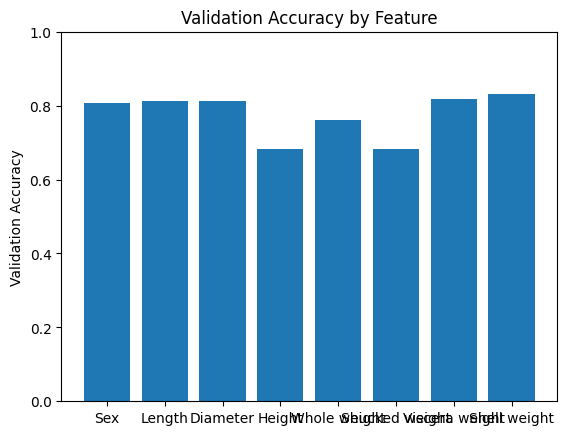

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
BASE_PATH = 'https://raw.githubusercontent.com/Alakhras/Abalone-Age/main/Abalone.csv'
dataset = pd.read_csv(BASE_PATH)

# Clean the dataset and preprocess
dataset = dataset[dataset['Height'] != 0]  # Remove rows with 'Height' == 0
dataset["Rings"] = np.where(dataset["Rings"] < 9, 0, 1)  # Binary classification for Rings
dataset['Sex'] = dataset['Sex'].map({'M': 1, 'F': 0, 'I': 2}).astype(float)

# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Data preparation
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
            'Shucked weight', 'Viscera weight', 'Shell weight']
target = 'Rings'

# Prepare training and validation dataset
train_data = dataset.sample(frac=0.8, random_state=42)
val_data = dataset.drop(train_data.index)

X_train = train_data[features].to_numpy() # Select only the features for training
y_train = train_data[target].to_numpy()
X_val = val_data[features].to_numpy() # Select only the features for validation
y_val = val_data[target].to_numpy()

# Normalize features only for the training set
X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)
X_TRAIN_normalized = (X_train - X_min) / (X_max - X_min)

# Normalize validation data using the same min and max as the training data
# Make sure to select only the feature columns for normalization
X_VALIDATION_normalized = (X_val - X_min) / (X_max - X_min)

# Function to create a simple model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(10, activation='relu', input_shape=(input_shape,)),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Train models for each feature individually
accuracies = {}
model_checkpoints = []

for i, feature in enumerate(features):
    model = create_model(1)  # Model for one feature only
    checkpoint = ModelCheckpoint(f'model_{feature}.keras', monitor='val_accuracy', save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True,verbose=1)
    model.fit(X_TRAIN_normalized[:, [i]], y_train, epochs=200, batch_size=8, verbose=0,
              validation_data=(X_val[:, [i]], y_val), callbacks=[checkpoint, early_stopping])
    loss, accuracy = model.evaluate(X_val[:, [i]], y_val, verbose=0)
    accuracies[feature] = accuracy
    model_checkpoints.append(checkpoint)
# Print accuracy for each feature
print("Accuracies for individual features:")
for feature, acc in accuracies.items():
    print(f"{feature}: {acc:.4f}")
# Plotting the accuracies of individual features
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Feature')
plt.show()



#Identify and Remove Least Important Features

In [ ]:
# Step 3: Identify least important features and remove them incrementally
sorted_features = sorted(accuracies.items(), key=lambda x: x[1])
new_accuracies = []
remaining_features = features.copy()

for feature, _ in sorted_features:
    remaining_features.remove(feature)  # Remove the least important feature
    if remaining_features:  # Check if there are remaining features
     # Create and fit a new model with the remaining features
        model = create_model(len(remaining_features))
        checkpoint = ModelCheckpoint('reduced_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
        early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True,verbose=0)
        model.fit(X_TRAIN_normalized[:, [features.index(f) for f in remaining_features]], y_train,
                  epochs=200, batch_size=8, verbose=0,
                  validation_data=(X_VALIDATION_normalized[:, [features.index(f) for f in remaining_features]], y_val),
                  callbacks=[checkpoint, early_stopping])

        # Evaluate the model
        loss, accuracy = model.evaluate(X_VALIDATION_normalized[:, [features.index(f) for f in remaining_features]], y_val, verbose=0)
        new_accuracies.append((remaining_features.copy(), accuracy))
# Print the new accuracies
print("Accuracies after feature reduction:")
for feature_set, acc in new_accuracies:
        print(f"Features: {feature_set}, Accuracy: {acc:.4f}")


Accuracies after feature reduction:
Features: ['Sex', 'Length', 'Diameter', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight'], Accuracy: 0.8491
Features: ['Sex', 'Length', 'Diameter', 'Whole weight', 'Viscera weight', 'Shell weight'], Accuracy: 0.8479
Features: ['Sex', 'Length', 'Diameter', 'Viscera weight', 'Shell weight'], Accuracy: 0.8455
Features: ['Length', 'Diameter', 'Viscera weight', 'Shell weight'], Accuracy: 0.8299
Features: ['Length', 'Viscera weight', 'Shell weight'], Accuracy: 0.8251
Features: ['Viscera weight', 'Shell weight'], Accuracy: 0.8263
Features: ['Shell weight'], Accuracy: 0.8323


#Plot the Results After Feature Reduction

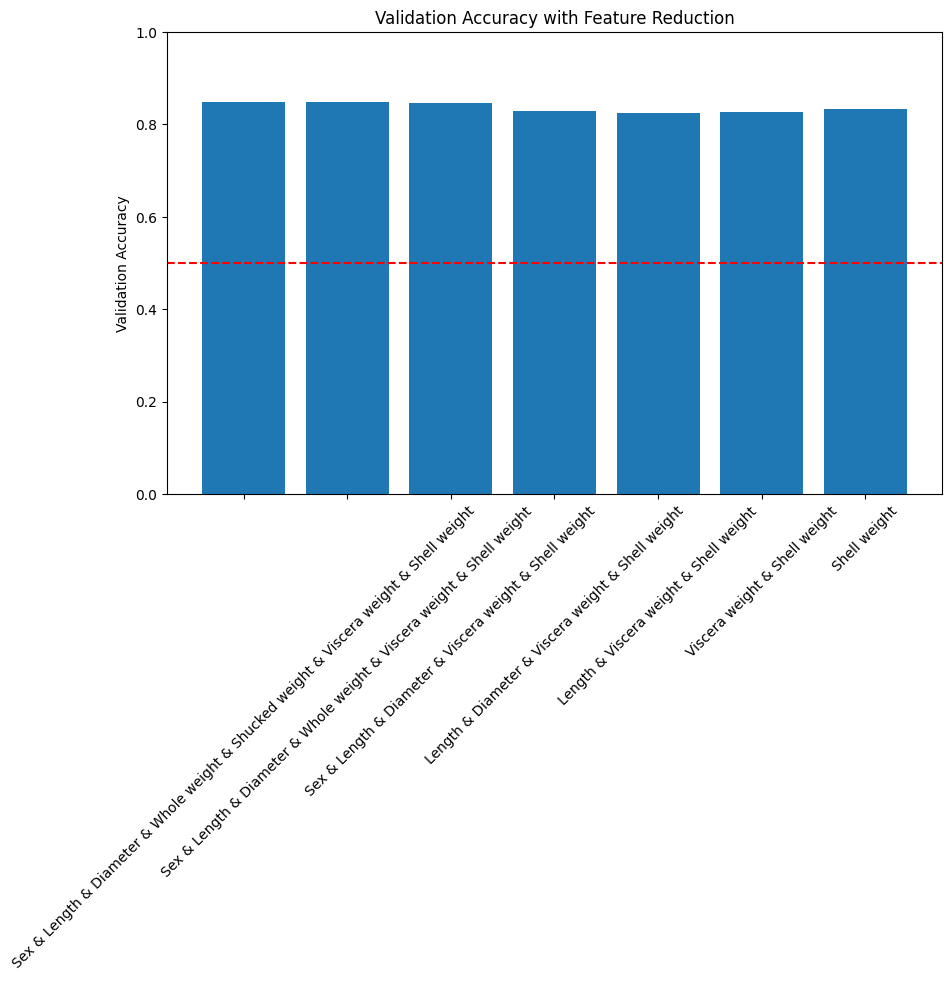

In [ ]:
# Step 4: Plot the results after feature reduction
x_labels = [' & '.join(feature_set) for feature_set, acc in new_accuracies]
y_values = [acc for _, acc in new_accuracies]

plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values)
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy with Feature Reduction')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 accuracy
plt.show()

#Compare the Original Model with the Reduced Feature Model


In [ ]:
# Step 5: Compare the original model with the reduced feature model
# Original model (using all features)
final_model = create_model(len(features))
checkpoint = ModelCheckpoint('final_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True,verbose=1)
final_model.fit(X_TRAIN_normalized, y_train, epochs=200, batch_size=8, verbose=0,
                validation_data=(X_VALIDATION_normalized, y_val), callbacks=[checkpoint, early_stopping])

# Evaluate the original model
loss, original_accuracy = final_model.evaluate(X_VALIDATION_normalized, y_val, verbose=0)

# Print the accuracies
print(f'Accuracy with all features: {original_accuracy:.4f}')


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 19.
Accuracy with all features: 0.8491


#Accuracy of the Best Model After Feature Reduction

In [ ]:
# Accuracy of the best model after feature reduction
if new_accuracies:
    reduced_accuracy = new_accuracies[-1][1]
    print(f'Best accuracy after feature reduction: {reduced_accuracy:.4f}')
else:
    print('No features remain after removal.')

Best accuracy after feature reduction: 0.8323


#Show Removed Features

In [ ]:
# Optional: Show the features that were removed and the final accuracy of the reduced model
removed_features = [feature for feature in sorted_features]
print('Removed Features:', ', '.join([feature[0] for feature in removed_features]))

Removed Features: Height, Shucked weight, Whole weight, Sex, Diameter, Length, Viscera weight, Shell weight


#Use model-agnostic methods such as LIME or Shapley values to derive feature importance.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
794/794 ━━━━━━

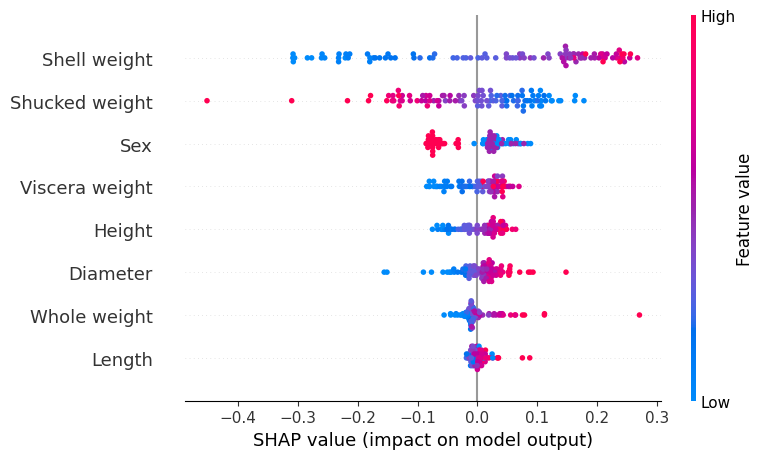

In [ ]:
import pandas as pd  # Import pandas if not already imported
import shap

# SHAP explainer initialization for feature importance
X_TRAIN_normalized_df = pd.DataFrame(X_TRAIN_normalized, columns=X.columns[:8]) # Assuming X is your original DataFrame
# SHAP explainer initialization
explainer = shap.KernelExplainer(best_model.predict, X_TRAIN_normalized_df.sample(100).values)  # Use the DataFrame for sampling

# Get a consistent set of 100 samples from XVALIDATION for SHAP
num_samples = min(100, X_VALIDATION_normalized.shape[0]) # Handle cases with fewer than 100 rows
X_validation_sample = X_VALIDATION_normalized[np.random.choice(X_VALIDATION_normalized.shape[0], num_samples, replace=False), :8]

# Calculate SHAP values
shap_values = explainer.shap_values(X_validation_sample)

# If shap_values is a list (for multi-output models), take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Ensure shap_values is a 2D array and then select the first output's values
if len(shap_values.shape) == 3:  # Check if it's 3D
    shap_values = shap_values[:, :, 0]  # Select the first output's values
elif len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(-1, 1)

# Verify shapes for consistency
print("Shape of SHAP values:", shap_values.shape)  # Expect (n_samples, n_features)
print("Shape of X_validation_sample:", X_validation_sample.shape)  # Expect (n_samples, n_features)
shap.summary_plot(shap_values, X_validation_sample, feature_names=X.columns.tolist())  # Remove [:, :, 0]
shap.initjs()  # Initialize JavaScript for visualizations

instance_to_explain = X_VALIDATION_normalized[0]  # Remove reshape, it's already 1D
expected_value = explainer.expected_value
if isinstance(expected_value, (np.ndarray, list)):  # Handle both ndarray and list
    expected_value = expected_value[0]  # Take the first element if it's a list or array



In [ ]:
# Create the force plot using the reshaped shap_values for a single output
shap.force_plot(expected_value, shap_values[0], instance_to_explain, feature_names=X.columns.tolist())

### Step 15: Strategies for Improving Performance

1. **Technical Enhancements**:
   - **Increase Epochs**: One approach to enhance model performance is to increase the number of training epochs to 100 or 150. This will provide the model with additional time to learn from the data.
   - **Add Additional Layers**: Enhancing the complexity of the neural network by adding more layers can increase its learning capacity, allowing it to capture more intricate patterns in the data.

2. **Balance the Dataset**:
   - It is crucial to ensure that the dataset contains an equal number of samples for each class. You can achieve this through:
     - **Oversampling**: Utilize techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate additional samples for the minority class.
     - **Undersampling**: Reduce the number of samples in the majority class to maintain balance within the dataset.

3. **Adjust Training and Validation Set Size**:
   - Modify the number of records in your training and validation sets based on your needs:
     - **Increase Rows**: If your dataset is limited, consider gathering more data to augment it.
     - **Decrease Rows**: If the majority class has a disproportionately large number of records, reducing its size may help in achieving better balance and model performance.

4. **Geographical Location**: Including the locations where abalones are collected can help us understand how different environments affect their characteristics.

5. **Abalone Species**: Adding information about the species will allow us to account for biological differences that may impact classification.

6. **Color**: The color of abalones can vary, and using this feature can help the model better distinguish between different types.

7. **Number of Predators**: Knowing how many natural predators are in the area could provide insights into the abalones' health and behaviors, potentially influencing classification.

8. **Living Environment**: Features such as the type of habitat (e.g., rocky, sandy) and environmental conditions (like pollution and temperature) are crucial for understanding their characteristics.

By implementing these strategies, we can enhance the effectiveness of our classification model.


In [ ]:
%%shell
jupyter nbconvert --to html AI_Final_SS.ipynb

[NbConvertApp] Converting notebook AI_Final_SS.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 5996471 bytes to AI_Final_SS.html
